In [1]:
import pandas as pd
import numpy as np

from nsepy import get_history
from datetime import date

from matplotlib import pyplot as plt
%matplotlib inline

import os
from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 5 year historic day wise data 
# ADANIPORTS is chosen for the prediction 

start_date = date(2014,1,1)
end_date = date(2018,12,31)

stock = get_history(symbol="ADANIPORTS", start=start_date, end= end_date)
stock.to_csv("ADANIPORTS.csv")

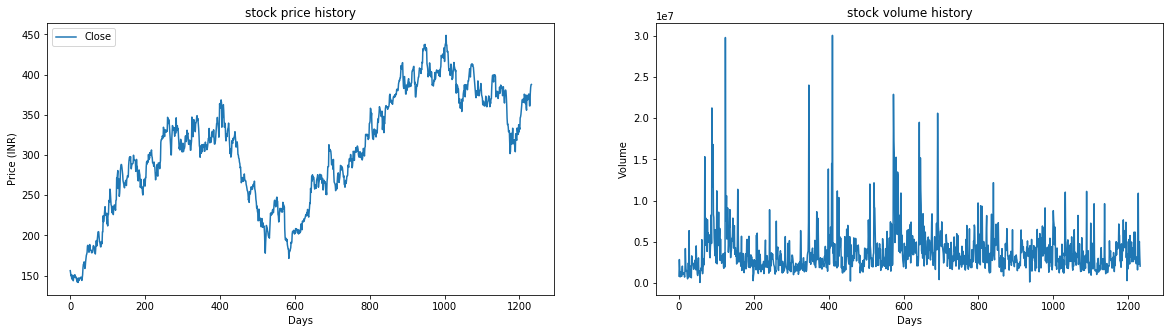

In [3]:
df = pd.read_csv("ADANIPORTS.csv")
#print("no.of. null values:", df.isna().sum()) # -- zero

f,(ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20,5))

ax1.plot(df["Close"])
ax1.set_title('stock price history')
ax1.set(xlabel='Days', ylabel='Price (INR)')
ax1.legend(['Close'], loc='upper left')

ax2.plot(df["Volume"])
ax2.set_title('stock volume history')
ax2.set(xlabel='Days', ylabel='Volume')

plt.show()

In [4]:
#choosing the below 5 parameters as features
train_cols = ["Open","High","Low","Close","Volume"]

# taking the first 1000 days as trianing data and the rest 233 days as test data 
df_train = df.iloc[:1000,:] 
df_test = df.iloc[1000:,:]

print('instances of train data:',len(df_train),"\n",'instances of test data:',len(df_test),"\n",'total instances:',len(df))

x = df_train.loc[:,train_cols].values

# Normalising the features
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# additional scaler to re-transform predicted y values back to original scale
y_scaler = MinMaxScaler()
y_scaler.fit(x[:,3].reshape(-1, 1))



# total data for plotting in the end 
k = df.loc[:,train_cols].values
X = min_max_scaler.transform(k)

instances of train data: 1000 
 instances of test data: 233 
 total instances: 1233


In [5]:
TIME_STEPS = 5 # No. of days the LSTM model will look back to predict the next value
BATCH_SIZE = 10


def build_timeseries(mat, y_col_index):
            
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

#trims dataset to a size that's divisible by BATCH_SIZE
def trim_dataset(mat, batch_size):
       
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [6]:
X, Y = build_timeseries(X, 3)
X = trim_dataset(X, BATCH_SIZE)
Y = trim_dataset(Y, BATCH_SIZE)

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (1228, 5, 5) (1228,)



length of time-series i/o (995, 5, 5) (995,)



length of time-series i/o (228, 5, 5) (228,)


In [7]:
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense,Dropout,LSTM

lr = 0.01

model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.6))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='linear'))

optimizer = optimizers.RMSprop(lr=lr)

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (10, 100)                 42400     
_________________________________________________________________
dropout_1 (Dropout)          (10, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (10, 20)                  2020      
_________________________________________________________________
dense_2 (Dense)              (10, 1)                   21        
Total params: 44,441
Trainable params: 44,441
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 990 samples, validate on 110 samples
Epoch 1/62
 - 2s - loss: 0.0332 - val_loss: 0.0226
Epoch 2/62
 - 0s - loss: 0.0106 - val_loss: 0.0050
Epoch 3/62
 - 1s - loss: 0.0604 - val_loss: 0.0112
Epoch 4/62
 - 1s - loss: 0.0128 - val_loss: 0.0100
Epoch 5/62
 - 1s - loss: 0.0091 - val_loss: 0.0069
Epoch 6/62
 - 1s - loss: 0.0071 - val_loss: 0.0150
Epoch 7/62
 - 1s - loss: 0.0067 - val_loss: 0.0076
Epoch 8/62
 - 1s - loss: 0.0058 - val_loss: 0.0037
Epoch 9/62
 - 1s - loss: 0.0064 - val_loss: 0.0059
Epoch 10/62
 - 1s - loss: 0.0065 - val_loss: 0.0053
Epoch 11/62
 - 1s - loss: 0.0057 - val_loss: 0.0064
Epoch 12/62
 - 1s - loss: 0.0057 - val_loss: 0.0049
Epoch 13/62
 - 1s - loss: 0.0049 - val_loss: 0.0039
Epoch 14/62
 - 1s - loss: 0.0051 - val_loss: 0.0064
Epoch 15/62
 - 1s - loss: 0.0050 - val_loss: 0.0057
Epoch 16/62
 - 1s - loss: 0.0042 - val_loss: 0.0062
Epoch 17/62
 - 1s - loss: 0.0046 - v

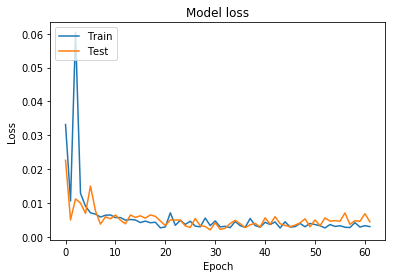

In [8]:
from keras.callbacks import CSVLogger

epochs = 62 #arrived after multiple iterations from 20 to 200 epochs

OUTPUT_PATH = os.getcwd()

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log_file' + '.log'), append=True)

model_fit = model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

plt.figure()
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(1220, 1)


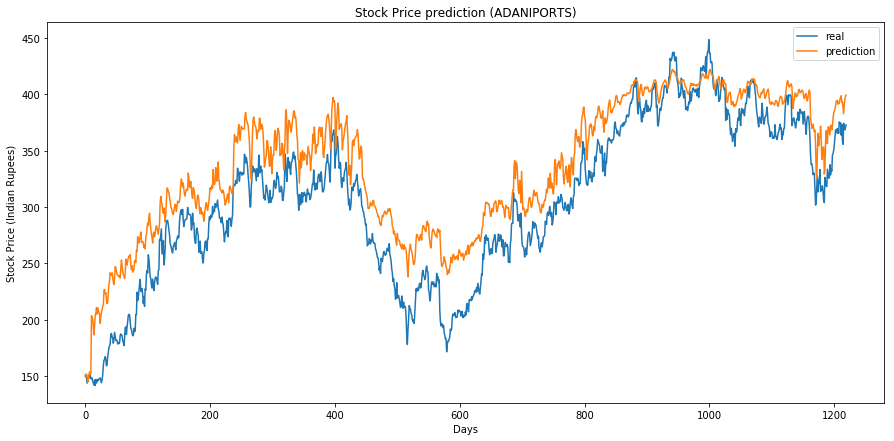

In [9]:
predictions = model.predict(X,batch_size = BATCH_SIZE)

print(predictions.shape)

pred_trans =  y_scaler.inverse_transform(predictions)
#pred_trans
Y_trans = y_scaler.inverse_transform(Y.reshape(-1,1))
#y_t_trans

plt.figure(figsize=(15,7))
plt.plot(Y_trans)
plt.plot(pred_trans)
plt.title('Stock Price prediction (ADANIPORTS)')
plt.legend(['real','prediction'])
plt.ylabel('Stock Price (Indian Rupees)')
plt.xlabel('Days')
plt.show()

plt.savefig('ADANIPORTS_LSTM.png')

In [10]:
# Saving the model architecture
with open('LSTM_ADANIPORTS_architecture.json', 'w') as f:
    f.write(model.to_json())
    
# Saving the model weights 
model.save_weights('LSTM_ADANIPORTS_weights.h5')